# RNN(LSTM) 실습해보기

In [85]:
#필요 모듈 import
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [86]:
#시드 고정 코드 블럭은 넘어가자

## 1. RNN 레이어 

In [87]:
#input 텐서 선언
# input = torch.ones(5, 3) #seq_size(일련된 데이터 개수), input_dim(입력 개수)
#위에 뜻은 순서를 가진 5개의 데이터 묶음을 3개씩 던진다는 것임
input = torch.ones(11, 5, 3) #3차원이면 앞에것은 batch_size
# print(input)


#RNN 레이어 선언
# rnn_layer = nn.RNN(input_size=3, hidden_size=10) #셀이 10개짜리 RNN선언
rnn_layer = nn.RNN(input_size=3, hidden_size=10, batch_first=True)
#batch_first 옵션은 만약 input 데이터가 3차원일 때 batch_size를 먼저 쓰니까
#True로 바꿔줘야함 -> 이거 False로 하면 순서 꼬임

#선언한 RNN레이어 구조 확인하기
print("\nActual values:")
print("weight_ih_l0:", rnn_layer.weight_ih_l0.data.shape)
print("weight_hh_l0:", rnn_layer.weight_hh_l0.data.shape)
print("bias_ih_l0:", rnn_layer.bias_ih_l0.data.shape)
print("bias_hh_l0:", rnn_layer.bias_hh_l0.data.shape)


Actual values:
weight_ih_l0: torch.Size([10, 3])
weight_hh_l0: torch.Size([10, 10])
bias_ih_l0: torch.Size([10])
bias_hh_l0: torch.Size([10])


In [88]:
#output 출력 확인해보기
output, hidden = rnn_layer(input) #임의의 input텐서 자료형을 rnn레이어로 통과시켜봄

print(output.shape) #배치사이즈, 히든 아웃풋 차원
print(hidden.shape)

torch.Size([11, 5, 10])
torch.Size([1, 11, 10])


# 2. LSTM 레이어 </br>
RNN은 개론만 잠깐 보고 실제 시계열 데이터 다룰때는 LSTM을 대중적으로 씀

In [89]:
#입력 텐서 정의
input = torch.ones(7, 3)
input_batch = torch.ones(11, 7, 3)

#레이어 정의
lstm_layer = nn.LSTM(input_size=3, hidden_size=10)
lstm_layer_batch = nn.LSTM(input_size=3, hidden_size=10, batch_first=True)

#선언한 LSTM레이어 구조 확인하기
print("\nActual values:")
#여기서 hidden_size * 4한 값이 hidden state의 파라미터 종류가 되버림
#LSTM은 cell의 게이트 종류가 4개라서 4배 뻥튀기됨
print("weight_ih_l0:", lstm_layer_batch.weight_ih_l0.data.shape) #
print("weight_hh_l0:", lstm_layer_batch.weight_hh_l0.data.shape)
print("bias_ih_l0:", lstm_layer_batch.bias_ih_l0.data.shape)
print("bias_hh_l0:", lstm_layer_batch.bias_hh_l0.data.shape)


Actual values:
weight_ih_l0: torch.Size([40, 3])
weight_hh_l0: torch.Size([40, 10])
bias_ih_l0: torch.Size([40])
bias_hh_l0: torch.Size([40])


In [90]:
#output 출력 해보기
output, (hidden, cell) = lstm_layer(input)

output_batch, (hidden_batch, cell_batch) = lstm_layer_batch(input_batch)

print(output_batch.shape) #배치사이즈, 히든 아웃풋 차원
print(hidden_batch.shape)
print(cell_batch.shape)

torch.Size([11, 7, 10])
torch.Size([1, 11, 10])
torch.Size([1, 11, 10])


# 3. 시계열 데이터(주식)를 LSTM으로 학습하기 </br>
데이터셋은 웹 크롤링 방식으로 가져온다.

In [91]:
from bs4 import BeautifulSoup
import requests #웹페이지 - 파이썬 통신 모듈

#웹 크롤링 방법

code = '005930' #네이버 주식이 제공하는 삼성전자 종목코드
url = 'https://finance.naver.com/item/sise_day.naver?code={}'.format(code)
#위 URL은 네이버 주식 검색해서 들어가면 나오는 코드임

header = {'User-agent':'Mozilla/5.0'}
req = requests.get(url, headers=header)
html = BeautifulSoup(req.text, 'lxml')  #여기까지 수행하면 '오늘자' 데이터만 나옴

# 페이지 전체 HTML 출력
# print(html.prettify())

pgrr = html.find('td', class_='pgRR')
s = pgrr.a['href'].split('=')
last_page = s[-1]

#데이터셋 구성하기
df = None

for page in tqdm(range(1, 100)): #이걸 해줘야 옛날 데이터도 다 긁어옴
    req = requests.get('{}&page={}'.format(url, page), headers=header)
    df = pd.concat([df, pd.read_html(req.text, encoding='euc-kr')[0]], ignore_index=True)

df.head()

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:04<00:00, 21.56it/s]


,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024.04.29,76700.0,보합0,77400.0,77600.0,76200.0,14249224.0
2,2024.04.26,76700.0,상승 400,77800.0,77900.0,76500.0,12755629.0
3,2024.04.25,76300.0,"하락 2,300",77300.0,77500.0,76300.0,15549134.0
4,2024.04.24,78600.0,"상승 3,100",77500.0,78800.0,77200.0,22166150.0


In [92]:
#위 긁어온 데이터를 전처리 해주자 (한글 삭제)

df.dropna(inplace=True)

#컬럼명 변경하기
df.columns = ["Date", "Close", "Gap", "Open", "High", "Low", "Amount"]

#필요없는 칼럼(전일비)는 제거하기
df.drop(["Gap"], axis=1, inplace=True)

#데이터 시간순으로 정렬하기
df.sort_values(["Date"], inplace=True) #데이터를 오름차순으로 정렬
df.reset_index(drop=True, inplace=True)

print(df.tail(10))#오름차순 정렬이니 맨 앞 데이터는 오래된 데이터임
print(df.shape)

           Date    Close     Open     High      Low      Amount
980  2024.04.16  80000.0  81200.0  81300.0  79400.0  31949845.0
981  2024.04.17  78900.0  80700.0  80800.0  78900.0  22611631.0
982  2024.04.18  79600.0  78800.0  80100.0  78300.0  21370190.0
983  2024.04.19  77600.0  78300.0  78700.0  76300.0  31317563.0
984  2024.04.22  76100.0  77400.0  77500.0  75100.0  30469477.0
985  2024.04.23  75500.0  76400.0  76800.0  75500.0  18717699.0
986  2024.04.24  78600.0  77500.0  78800.0  77200.0  22166150.0
987  2024.04.25  76300.0  77300.0  77500.0  76300.0  15549134.0
988  2024.04.26  76700.0  77800.0  77900.0  76500.0  12755629.0
989  2024.04.29  76700.0  77400.0  77600.0  76200.0  14249224.0
(990, 6)


In [93]:
#훈련용, 학습용 데이터로 분리하기
div_idx = len(df) - 5 #데이터에서 가장 마지막 5개 데이터로 분리할거임

train_df = df.loc[:div_idx-1]
test_df = df.loc[div_idx:]

print(train_df.tail())
print(test_df)

#훈련 데이터에서 idx랑 data는 기능이 겹치니 삭제?
train_df.drop(["Date"], axis=1, inplace=True)

#스케일링 작업 수행
scaler = StandardScaler()
scaler.fit(train_df)

s_train_df = scaler.transform(train_df)
s_test_df = scaler.transform(test_df.drop(["Date"], axis=1))

           Date    Close     Open     High      Low      Amount
980  2024.04.16  80000.0  81200.0  81300.0  79400.0  31949845.0
981  2024.04.17  78900.0  80700.0  80800.0  78900.0  22611631.0
982  2024.04.18  79600.0  78800.0  80100.0  78300.0  21370190.0
983  2024.04.19  77600.0  78300.0  78700.0  76300.0  31317563.0
984  2024.04.22  76100.0  77400.0  77500.0  75100.0  30469477.0
           Date    Close     Open     High      Low      Amount
985  2024.04.23  75500.0  76400.0  76800.0  75500.0  18717699.0
986  2024.04.24  78600.0  77500.0  78800.0  77200.0  22166150.0
987  2024.04.25  76300.0  77300.0  77500.0  76300.0  15549134.0
988  2024.04.26  76700.0  77800.0  77900.0  76500.0  12755629.0
989  2024.04.29  76700.0  77400.0  77600.0  76200.0  14249224.0


C:\Users\Z13_ASH\AppData\Local\Temp\ipykernel_21128\3644193120.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(["Date"], axis=1, inplace=True)


위에서 정리한 데이터는 말 그대로 1차 전처리임</br>
학습이 가능하게끔 학습용 dataset(텐서자료형)으로 2차 전처리

In [94]:
#입출력 차원 정의(define the window size) -> 슬라이딩 윈도우 쓴다 보면 됨...
input_window = 30 #30개씩 sequences 데이터가 들어갈거
output_window = 5 #출력하는건 sequence 데이터가 5개

#데이터셋 생성
data = torch.tensor(s_train_df, dtype=torch.float32)
target = torch.tensor(s_train_df.T[0], dtype=torch.float32)
#target는 평가용 데이터에서 Close데이터를 타겟이니 T[0]이 붙음
#그냥 명확하게 'close'를 사요하자

#시계열 데이터(입력/출력) 변수 만들기
X, Y = [], []
for i in range(len(data) - input_window - output_window + 1):
    a = i + input_window
    b = i + input_window + output_window
    X.append(data[i:a])
    Y.append(target[a:b])

#텐서 데이터셋 생성
dataset = TensorDataset(torch.stack(X), torch.stack(Y))
print(dataset[0][0].shape) #30일짜리 seq_size, inputsize는 (close, open, high, low amount) 5개 칼럼
print(dataset[0][1].shape) #출력데이터는 30일짜리(seq) close 단하나

#데이터로더 생성
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#생성된 데이터로더의 길이 확인
print(len(dataloader))


torch.Size([30, 5])
torch.Size([5])
30


## LSTM Net 만들고 학습시키기

In [95]:
#모델 설계

class My_Forecasting_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(My_Forecasting_Model, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #LSTM레이어 설계
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, output_size)

        #전사과정 설계
    def forward(self, x):
        output, (hidden_output, cell_output) = self.lstm(x)
        hidden_output = hidden_output.view(-1, self.hidden_size)
        
        out = self.fc1(hidden_output)
        out = F.relu(out)

        out = self.fc2(out)

        return out
        

ex_model = My_Forecasting_Model(input_size=5, hidden_size=30, output_size=5)

### 훈련 시작

In [96]:
#GPU로 이전해야 할것들 다 이전하기

#GPU사용 가능 확인하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#모델 GPU로 보내기
print(ex_model.to(device))
#모델 파라미터가 GPU에 들어갓는지 확인
print(next(ex_model.parameters()).device)

#로스 함수 및 옵티마이저 선언
optimizer = torch.optim.Adam(ex_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

cuda
My_Forecasting_Model(
  (lstm): LSTM(5, 30, batch_first=True)
  (fc1): Linear(in_features=30, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=5, bias=True)
)
cuda:0


In [97]:
#훈련 코드 작성

num_epoch = 100
lossess = []

for epoch in tqdm(range(num_epoch)):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        #전사과정
        outputs = ex_model(inputs)
        loss = criterion(outputs, labels)

        lossess.append(loss.item()) #로스값 저장하기

        optimizer.zero_grad() #옵티마이저 초기화

        #백프로파게이션
        loss.backward()
        optimizer.step() #모델 파라미터 업데이트

        #중간중간 데이터 출력
        if (epoch+1) % 10 == 0 and (i % 15 == 0 and i > 1): #10 에포크 + 스탭은 절반 지낫을 때
            print(f"에포크 : {epoch+1}/{num_epoch}, 이터레이션 : {i+1}/{len(dataloader)}, 로스값 : {loss.item():.4f}")
        


 10%|█         | 10/100 [00:01<00:08, 10.50it/s]

에포크 : 10/100, 이터레이션 : 16/30, 로스값 : 0.0256


 20%|██        | 20/100 [00:02<00:07, 10.48it/s]

에포크 : 20/100, 이터레이션 : 16/30, 로스값 : 0.0274


 30%|███       | 30/100 [00:02<00:06, 10.58it/s]

에포크 : 30/100, 이터레이션 : 16/30, 로스값 : 0.0193


 40%|████      | 40/100 [00:03<00:05, 10.55it/s]

에포크 : 40/100, 이터레이션 : 16/30, 로스값 : 0.0215


 50%|█████     | 50/100 [00:04<00:04, 10.50it/s]

에포크 : 50/100, 이터레이션 : 16/30, 로스값 : 0.0239


 60%|██████    | 60/100 [00:05<00:03, 10.40it/s]

에포크 : 60/100, 이터레이션 : 16/30, 로스값 : 0.0193


 70%|███████   | 70/100 [00:06<00:02, 10.59it/s]

에포크 : 70/100, 이터레이션 : 16/30, 로스값 : 0.0192


 80%|████████  | 80/100 [00:07<00:02,  8.96it/s]

에포크 : 80/100, 이터레이션 : 16/30, 로스값 : 0.0166


 91%|█████████ | 91/100 [00:09<00:00,  9.02it/s]

에포크 : 90/100, 이터레이션 : 16/30, 로스값 : 0.0167


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]

에포크 : 100/100, 이터레이션 : 16/30, 로스값 : 0.0154


## Loss값을 시각화 해보기

c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49496 (\N{HANGUL SYLLABLE SYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Z13_ASH\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools

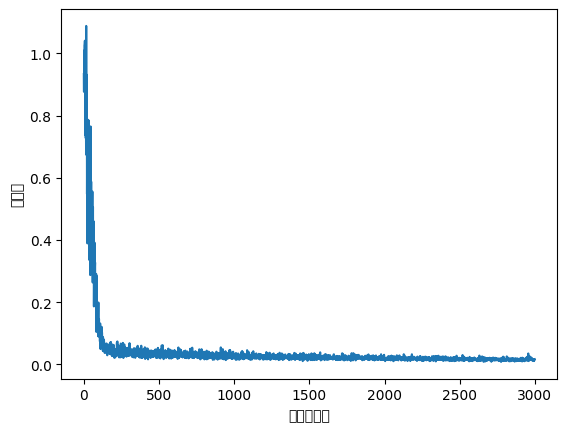

In [98]:
import matplotlib.pyplot as plt

plt.plot(lossess)
plt.xlabel('이터레이션')
plt.ylabel('로스값')
plt.show()

In [105]:
#마지막 모델 평가부분

y_real = s_test_df.T[0]
print('스케일링된 실제 값 : ', [format(x, ".4f") for x in y_real])

input = torch.tensor(s_train_df[-30:], dtype=torch.float32)
y_pred = ex_model(input.to(device)).detach().cpu().squeeze().numpy()
print('스케일링된 예측 값 : ', [format(x, ".4f") for x in y_pred])


#스케일링 된 값을 원복하기
inv_trans_y_real = scaler.inverse_transform(s_test_df).T[0]
inv_trans_y_real = [round(x) for x in inv_trans_y_real]
print("실제 주식 : ", inv_trans_y_real)

inv_trans_y_pred = y_pred * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
inv_trans_y_pred = [round(x) for x in inv_trans_y_pred]
print("예측 주식 : ", inv_trans_y_pred)

#RMSE구하기
rmse = np.sqrt(mean_squared_error(inv_trans_y_pred, inv_trans_y_real))

print("오차는?(RMSE) : ", format(rmse, ".2f"))


스케일링된 실제 값 :  ['0.7312', '1.0611', '0.8163', '0.8589', '0.8589']
스케일링된 예측 값 :  ['1.0147', '1.1191', '1.1803', '1.2788', '1.3606']
실제 주식 :  [75500, 78600, 76300, 76700, 76700]
예측 주식 :  [78164, 79145, 79720, 80645, 81413]
오차는?(RMSE) :  3372.41
